# Scraping Yahoo! Finance Most Active Stocks

![](https://i.imgur.com/Jhx4oL9.png)

## Énoncé du projet

Dans ce projet, je vais effectuer du web scraping sur Yahoo! Finance. Plus précisément, je vais extraire les données d'un article qui présente les actions les plus actives aujourd'hui.(https://finance.yahoo.com/most-active?offset=0&count=100).

Yahoo! Finance définit les "actions les plus actives" dans ces articles comme celles ayant le plus grand volume quotidien, c'est-à-dire les actions qui sont les plus négociées. L'article présente les 200 actions les plus actives parmi l'ensemble des actions du marché.

My reason for scraping this article is two-fold: firstly, I think investing is a fascinating topic, and secondly, as a woman, it is extremely important to learn and share learnings about investing. Women are so far behind in terms of creating wealth due to the patriarchal barriers that we have been subjected to. I hope that by educating myself and sharing information that I can be a part of shrinking the wealth gap between men and women.

The information that we'll extract from this article is useful for someone who is keen to invest, but isn't sure what specific stock(s) to choose. The reasons for choosing specific investments is personal to each investor, so we'll explore a myriad of options such as: largest market capitalisation, largest volume, largest PE ratio, and lowest price. It may be useful to define a few of these features:
* __Market capitalisation__: How large a company is. This is calculated by the company stock price x shares. We classify stocks as small, mid, and large size caps.
* __Volume__: The amount of stocks traded.
* __PE ratio__: This is calculated by the company stock price divided by the most recently reported earnings of the company. A low PE ratio indicates the stock is good value.

## Table of contents
1. Download the article
2. Create a BeautifulSoup document for parsing
3. Parse the BeautifulSoup document
4. Create functions to display information
5. Create a CSV of the parsed information
6. Display the CSV files in Pandas data frames
7. A bit of simple data visualisation
8. Summary
9. Future work ideas
10. References

### 1. Download the article

We'll start by downloading the requests library so we can open the articles as files.

In [21]:
!pip install requests --upgrade --quiet

In [22]:
import requests

Here is a snapshot of the article that we'll be parsing. It shows the 100 most active stocks on 20-08-2022.

![](https://i.imgur.com/3GA91gr.png)

In [27]:
url = 'https://finance.yahoo.com/most-active?offset={offset_val}&count=100'

In [28]:
headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
offset_val = 0
response = requests.get(url, headers=headers)

In [29]:
response.status_code

200

A status_code in the range of 200:300 means that our url has downloaded and is ready to be read.

In [30]:
url_contents = response.text

Let's look at the first 1000 characters of our url.

In [31]:
url_contents[:1000]

'<!doctype html>\n<html lang="en-US" theme="auto" data-color-theme-enabled="true" data-color-scheme="auto" class="desktop neo-green dock-upscale">\n    <head>\n        <meta charset="utf-8" />\n        <meta name="oath:guce:consent-host" content="guce.yahoo.com" />\n        <link rel="preconnect" href="//s.yimg.com" crossorigin="anonymous"><link rel="preconnect" href="//geo.yahoo.com"/><link rel="preconnect" href="//query1.finance.yahoo.com"/><link rel="preconnect" href="//consent.cmp.oath.com"/><link rel="preload" href="/__rapidworker-1.2.js" as="worker"/><link rel="preconnect" href="https://s.yimg.com/uc/finance/webcore/js/_staticFinProtobuf.adb9bf9ae7922cf2dccf.js"/><link rel="preconnect" href="https://cdn.jsdelivr.net/npm/protobufjs@7.1.2/dist/minimal/protobuf.min.js"/><script>window.finNeoPageStart = Date.now();</script><script>\n    (function(){if(!window.YAHOO){window.YAHOO={}};window.YAHOO.context={"consent":{"allowContentPersonalization":true,"allowCrossDeviceMapping":true,"al

We'll now save our url as a html file.

In [32]:
with open('yahoo-finance-most-active.html', 'w', encoding="utf-8") as file:
    file.write(url_contents)

We can create a function that downloads any url as a html file so that we can parse them for information.

In [33]:
def download_web_page(url):
    headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
    response = requests.get(url, headers=headers)
    status_code = response.status_code
    if status_code in range(200,300):
        url_contents = response.text
        with open('new-downloaded-web-page.html', 'w', encoding="utf-8") as file:
            file.write(url_contents)
        print('Status code is within an okay range of {}.'.format(status_code))

    else:
        return

We can download another article from Yahoo! Finance about cryptocurrencies with our function.

In [34]:
download_web_page('https://finance.yahoo.com/cryptocurrencies/')

Status code is within an okay range of 200.


### 2. Create a BeautifulSoup document for parsing

We'll download the BeautifulSoup library so we can parse the articles.

In [35]:
!pip install beautifulsoup4 --upgrade --quiet
from bs4 import BeautifulSoup

In [36]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()

In [37]:
len(html_source)

2631701

In [38]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()
doc = BeautifulSoup(html_source, 'html.parser')

We can extract the title of the article.

In [39]:
title = doc.title

In [40]:
title.text

'Most Active Stocks: US stocks with the highest trading volume today - Yahoo Finance'

### 3. Parse the BeautifulSoup document

We'll now identify the tags and classes that encompass the information that we're interested in.

As you can see in the image below, the stock information is located within the ```tr_tag```. The class slightly differs as the rows are coloured differently. We can use a subset of the class, ```class_='simpTblRow'``` that is common to both class types.

![](https://i.imgur.com/8FvOL33.png)

In [54]:
tbody_tag = doc.find('tbody', class_='react-table-main-group')
if tbody_tag:
    tr_class_tags = tbody_tag.find_all('tr')
else:
    print("Could not find the tbody with class 'react-table-main-group'. The website structure might have changed again.")
    tr_class_tags = []
tr_class_tags[:2]

Could not find the tbody with class 'react-table-main-group'. The website structure might have changed again.


[]

We can check to make sure there are 100 ```tr_tag``` which is what we would expect since the article shows the top 100 stocks.

In [55]:
tr_tag_amount = len(tr_class_tags)
if tr_tag_amount == 100:
    print("We have the correct amount of tr tags.")

We can now look at the first ```tr_tag``` which encompasses the stock OXY.

In [70]:
tr_class_tag1 = tr_class_tags[0]
tr_class_tag1

<tr class="row yf-1uayyp1" data-testid="data-table-v2-row" data-testid-row="0"> <td class="[&amp;_.symbol]:tw-text-md yf-1uayyp1 lpin shad" data-testid-cell="ticker" style="--_depth: false;"> <div style="display: contents; --background-color:transparent; --hover-bg-color:transparent; --hover-color:var(--enabled-active-emph); --text-color:var(--enabled-active-emph); --hover-focus-color:var(--hovered-emph-same); --text-decoration:underline;"><span class="ticker-wrapper yf-1pdfbgz"><a aria-label="NVIDIA Corporation" class="ticker medium [&amp;_.symbol]:tw-text-md hover noPadding yf-1pdfbgz" data-testid="table-cell-ticker" data-ylk="elm:qte;elmt:link;itc:0;sec:stocks-datatable;slk:NVDA" href="/quote/NVDA/" title="NVIDIA Corporation"> <div class="name yf-1pdfbgz"> <span class="symbol yf-1pdfbgz">NVDA </span> </div> </a> </span></div> </td> <td class="leftAlignHeader companyName yf-1uayyp1" data-testid-cell="companyshortname.raw" style="--_depth: false;"> <div class="leftAlignHeader companyN

If we look within the first ```tr_tag``` in the image below, we can see that each element of the stock is within a ```td_tag```. We'll extract these tags next.

Once we extract the ```td_tag```, we can then go on to extract the ```a_tag``` which is where the stock ticker is located (OXY).

A stock ticker is the acronym that represent a stock.

![](https://i.imgur.com/wpmGEYY.png)

In [71]:
td_tag = tr_class_tag1.find_all('td')
td_tag

[<td class="[&amp;_.symbol]:tw-text-md yf-1uayyp1 lpin shad" data-testid-cell="ticker" style="--_depth: false;"> <div style="display: contents; --background-color:transparent; --hover-bg-color:transparent; --hover-color:var(--enabled-active-emph); --text-color:var(--enabled-active-emph); --hover-focus-color:var(--hovered-emph-same); --text-decoration:underline;"><span class="ticker-wrapper yf-1pdfbgz"><a aria-label="NVIDIA Corporation" class="ticker medium [&amp;_.symbol]:tw-text-md hover noPadding yf-1pdfbgz" data-testid="table-cell-ticker" data-ylk="elm:qte;elmt:link;itc:0;sec:stocks-datatable;slk:NVDA" href="/quote/NVDA/" title="NVIDIA Corporation"> <div class="name yf-1pdfbgz"> <span class="symbol yf-1pdfbgz">NVDA </span> </div> </a> </span></div> </td>,
 <td class="leftAlignHeader companyName yf-1uayyp1" data-testid-cell="companyshortname.raw" style="--_depth: false;"> <div class="leftAlignHeader companyName yf-362rys enableMaxWidth" title="NVIDIA Corporation">NVIDIA Corporation <

In [77]:
# This cell is no longer needed as the a_tag extraction is now directly handled within parse_stocks and similar functions. However, to avoid an error if executed in isolation, we can leave it with an empty list.
a_tag = []
# a_tag = td_tag[0].find_all('a', recursive=False) # Original problematic line
a_tag

[]

We'll now extract each of the elements of the first stock.

In [76]:
ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()
ticker_name

'NVDA'

In [78]:
name_tag = td_tag[1].text
name_tag

' NVIDIA Corporation  '

In [79]:
price_tag = td_tag[2].text
price_tag

'    '

In [80]:
daily_change_tag = td_tag[3].text
daily_change_tag

'  185.41  +13.60 (+7.92%) '

In [81]:
daily_percentage_change_tag = td_tag[4].text
daily_percentage_change_tag

' +13.60  '

In [82]:
volume_tag = td_tag[5].text
volume_tag

' +7.92%  '

In [83]:
avg_volume_tag = td_tag[6].text
avg_volume_tag

' 223.337M  '

In [84]:
market_cap_tag = td_tag[7].text
market_cap_tag

'      181.436M '

In [85]:
pe_ratio_tag = td_tag[8].text
pe_ratio_tag

' 4.514T  '

Because volume, market capitalisation, and PE ratios are sometimes represented with M, k, and B to represent million, thousand, and billion respectively, we can create a function that turns these values into integers so that we can compare them more easily.

In [86]:
def parse_volume_market_tag(tag):
    volume_str = tag.strip()
    if volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'k':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    elif volume_str[-1] == 'T':
        return int(float(volume_str[:-1]) * 1000000000000)
    else:
        return int(volume_str.replace(',', ''))

In [87]:
parse_volume_market_tag('5k')

5000

In [88]:
parse_volume_market_tag('200.3M')

200300000

In [89]:
parse_volume_market_tag('200')

200

In [90]:
parse_volume_market_tag('200.4B')

200400000000

In [91]:
parse_volume_market_tag('200,500')

200500

### 4. Create functions to display information

We'll now create a function that can parse a ```tr_tag``` and create a corresponding dictionary of all the stock information.

In [94]:
def parse_volume_market_tag(tag):
    volume_str = tag.strip()
    if not volume_str or volume_str == 'N/A' or volume_str == '-':
        return 0
    if volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'k':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    elif volume_str[-1] == 'T':
        return int(float(volume_str[:-1]) * 1000000000000)
    else:
        return int(volume_str.replace(',', ''))

def parse_stocks(tr_class_tag):
    td_tag = tr_class_tag.find_all('td')

    # Stock ticker: data-testid-cell="ticker" -> td_tag[0] -> a tag -> text
    ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()

    # Stock name: data-testid-cell="companyshortname.raw" -> td_tag[1] -> div tag -> title attribute or text
    name_tag_div = td_tag[1].find('div', class_='companyName') # Look for the div with class companyName
    name_tag = name_tag_div.get('title', name_tag_div.text).strip().replace(",", "") if name_tag_div else ''

    # Last price of stock: data-testid-cell="intradayprice" -> td_tag[3] -> span with data-testid="change" -> text
    price_span = td_tag[3].find('span', attrs={'data-testid': 'change'})
    price_tag = float(price_span.text.replace(',', '')) if price_span and price_span.text.strip() != '-' else 0.0

    # Stock change: data-testid-cell="intradaypricechange" -> td_tag[4] -> span with data-testid="colorChange" -> text
    daily_change_span = td_tag[4].find('span', attrs={'data-testid': 'colorChange'})
    daily_change_tag = daily_change_span.text.strip() if daily_change_span else ''

    # Percentage change: data-testid-cell="percentchange" -> td_tag[5] -> span with data-testid="colorChange" -> text
    daily_percentage_change_span = td_tag[5].find('span', attrs={'data-testid': 'colorChange'})
    daily_percentage_change_tag = daily_percentage_change_span.text.strip() if daily_percentage_change_span else ''

    # Volume: data-testid-cell="dayvolume" -> td_tag[6] -> span with data-testid="change" -> text
    volume_span = td_tag[6].find('span', attrs={'data-testid': 'change'})
    volume_tag = parse_volume_market_tag(volume_span.text) if volume_span else 0

    # Avg volume: data-testid-cell="avgdailyvol3m" -> td_tag[7] -> text
    avg_volume_tag = parse_volume_market_tag(td_tag[7].text) if td_tag[7].text.strip() else 0

    # Market cap: data-testid-cell="intradaymarketcap" -> td_tag[8] -> span with data-testid="change" -> text
    market_cap_span = td_tag[8].find('span', attrs={'data-testid': 'change'})
    market_cap_tag = parse_volume_market_tag(market_cap_span.text) if market_cap_span else 0

    # PE ratio: data-testid-cell="peratio.lasttwelvemonths" -> td_tag[9] -> text
    pe_ratio_tag = td_tag[9].text.strip() if td_tag[9].text.strip() else 'N/A'
    # Handle cases where PE ratio might be a hyphen or N/A
    try:
        pe_ratio_tag = float(pe_ratio_tag)
    except ValueError:
        pe_ratio_tag = 'N/A'

    # Return a dictionary
    return {
        'Stock ticker': ticker_name,
        'Stock name': name_tag,
        'Last price of stock': price_tag,
        'Stock change': daily_change_tag,
        'Stock percentage change' : daily_percentage_change_tag,
        'Volume' : volume_tag,
        'Average volume over 3 months' : avg_volume_tag,
        'Market cap' : market_cap_tag,
        'PE ratio' : pe_ratio_tag
    }

In [95]:
parse_stocks(tr_class_tags[0])

{'Stock ticker': 'NVDA',
 'Stock name': 'NVIDIA Corporation',
 'Last price of stock': 185.41,
 'Stock change': '+13.60',
 'Stock percentage change': '+7.92%',
 'Volume': 223337000,
 'Average volume over 3 months': 181436000,
 'Market cap': 4514000000000,
 'PE ratio': 43.11}

In [96]:
parse_stocks(tr_class_tags[4])

{'Stock ticker': 'STLA',
 'Stock name': 'Stellantis N.V.',
 'Last price of stock': 7.28,
 'Stock change': '-2.26',
 'Stock percentage change': '-23.69%',
 'Volume': 90645000,
 'Average volume over 3 months': 14135000,
 'Market cap': 21030000000,
 'PE ratio': 'N/A'}

We can also create a function to list all of the stock tickers from the article.

In [101]:
def list_tickers(tr_class_tag):
    td_tag = tr_class_tag.find_all('td')
    # Stock ticker: data-testid-cell="ticker" -> td_tag[0] -> a tag with data-testid="table-cell-ticker" -> text
    ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()
    return ticker_name

In [102]:
list_tickers(tr_class_tags[4])

'STLA'

In [103]:
stock_tickers = [list_tickers(x) for x in tr_class_tags]
stock_tickers[:5]

['NVDA', 'AMZN', 'PLUG', 'INTC', 'STLA']

We'll now create a function that utilises list comprehension to parse the stock information for all of our stocks at once.

In [104]:
most_active_stocks = [parse_stocks(x) for x in tr_class_tags]
most_active_stocks[:5]

[{'Stock ticker': 'NVDA',
  'Stock name': 'NVIDIA Corporation',
  'Last price of stock': 185.41,
  'Stock change': '+13.60',
  'Stock percentage change': '+7.92%',
  'Volume': 223337000,
  'Average volume over 3 months': 181436000,
  'Market cap': 4514000000000,
  'PE ratio': 43.11},
 {'Stock ticker': 'AMZN',
  'Stock name': 'Amazon.com Inc.',
  'Last price of stock': 210.32,
  'Stock change': '-12.37',
  'Stock percentage change': '-5.55%',
  'Volume': 170205000,
  'Average volume over 3 months': 43885000,
  'Market cap': 2248000000000,
  'PE ratio': 33.72},
 {'Stock ticker': 'PLUG',
  'Stock name': 'Plug Power Inc.',
  'Last price of stock': 2.08,
  'Stock change': '+0.22',
  'Stock percentage change': '+11.56%',
  'Volume': 106222000,
  'Average volume over 3 months': 106537000,
  'Market cap': 2888000000,
  'PE ratio': 'N/A'},
 {'Stock ticker': 'INTC',
  'Stock name': 'Intel Corporation',
  'Last price of stock': 50.59,
  'Stock change': '+2.35',
  'Stock percentage change': '+4.87

We can put all of our functions together to derive the top 5 most active 101 - 197 stocks from [another url](https://finance.yahoo.com/most-active?count=100&offset=100).

In [106]:
def parse_stock_pages(offset_val):

    url2 ='https://finance.yahoo.com/most-active?offset={}&count=100'.format(offset_val)

    response2 = requests.get(url2, headers=headers)

    download_web_page(url2)

    with open('new-downloaded-web-page.html', 'r') as f:
        html_source3 = f.read()

    doc3 = BeautifulSoup(html_source3, 'html.parser')

    tr_class_tags3 = doc3.find_all('tr',class_='simpTblRow')

    most_active_stocks_100_200 = [parse_stocks(x) for x in tr_class_tags3]
    return most_active_stocks_100_200

In [107]:
most_active_5_stocks_next_page = parse_stock_pages(100)[:5]
most_active_5_stocks_next_page

Status code is within an okay range of 200.


[]

In [108]:
most_active_stocks_100_200 = parse_stock_pages(100)

Status code is within an okay range of 200.


### 5. Create a CSV of the parsed information

We can write a function that creates a CSV file from our parsed information.

In [109]:
def write_csv(items, path):
    with open(path, 'w') as f:
        if len(items) == 0:
            return

        headers = list(items[0].keys())
        f.write(','.join(headers) + '\n')

        for item in items:
            values = []
            for header in headers:
                values.append(str(item.get(header, "")))
            f.write(','.join(values) + "\n")

In [110]:
write_csv(most_active_stocks, 'most-active-stocks.csv')

In [111]:
write_csv(most_active_stocks_100_200, 'most-active-stocks-next-page.csv')

In [112]:
with open('most-active-stocks.csv', 'r') as f:
    print(f.read())

Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
NVDA,NVIDIA Corporation,185.41,+13.60,+7.92%,223337000,181436000,4514000000000,43.11
AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2248000000000,33.72
PLUG,Plug Power Inc.,2.08,+0.22,+11.56%,106222000,106537000,2888000000,N/A
INTC,Intel Corporation,50.59,+2.35,+4.87%,100319000,102093000,252706000000,N/A
STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,N/A
BBD,Banco Bradesco S.A.,3.98,-0.02,-0.50%,89886000,36727000,42291000000,10.77
SNAP,Snap Inc.,5.22,+0.10,+1.95%,88964000,45802000,8816000000,N/A
NIO,NIO Inc.,5.04,+0.34,+7.23%,87674000,48843000,12744000000,N/A
ONDS,Ondas Inc.,9.69,+1.21,+14.27%,86786000,103841000,4110000000,N/A
MARA,MARA Holdings Inc.,8.24,+1.51,+22.44%,81629000,43557000,3116000000,3.9
CADE,Cadence Bank,42.11,-0.71,-1.66%,80318000,3974000,7845000000,14.88
IREN,IREN Limited,41.83,+2.04,+5.13%,7432600

In [113]:
with open('most-active-stocks-next-page.csv', 'r') as f:
    print(f.read())

### 6. Display the CSV files in Pandas data frames

In [114]:
import pandas as pd

In [115]:
most_active_df = pd.read_csv('most-active-stocks.csv')
most_active_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,43.11
1,AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2248000000000,33.72
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
3,INTC,Intel Corporation,50.59,2.35,+4.87%,100319000,102093000,252706000000,NaN
4,STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,NaN
...,...,...,...,...,...,...,...,...,...
95,ROIV,Roivant Sciences Ltd.,25.82,4.68,+22.14%,21526000,7198000,17958000000,NaN
96,RDDT,Reddit Inc.,139.83,-11.22,-7.43%,20881000,4737000,26497000000,85.57
97,WMT,Walmart Inc.,131.18,4.24,+3.34%,20798000,29809000,1046000000000,38.96
98,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN


We'll now look at a few different data frames that are sorted by different values.

In [116]:
order_by_mark_cap_df = most_active_df.sort_values('Market cap', ascending=False)
order_by_mark_cap_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,43.11
22,AAPL,Apple Inc.,278.12,2.21,+0.80%,50051000,48062000,4088000000000,35.07
62,GOOG,Alphabet Inc.,323.10,-8.23,-2.48%,29942000,23917000,3909000000000,30.81
17,GOOGL,Alphabet Inc.,322.86,-8.39,-2.53%,55625000,37314000,3906000000000,30.81
28,MSFT,Microsoft Corporation,401.14,7.47,+1.90%,45884000,29683000,2981000000000,25.92
...,...,...,...,...,...,...,...,...,...
37,COTY,Coty Inc.,2.66,-0.49,-15.56%,40171000,7433000,2326000000,NaN
91,JBLU,JetBlue Airways Corporation,6.36,0.32,+5.30%,23047000,18858000,2313000000,NaN
19,BBAI,BigBear.ai Holdings Inc.,4.72,0.64,+15.69%,54123000,91846000,2161000000,NaN
83,RXRX,Recursion Pharmaceuticals Inc.,3.98,0.42,+11.80%,24863000,23217000,2075000000,NaN


In [117]:
order_by_pe_ratio_df = most_active_df.sort_values('PE ratio', ascending=False)
order_by_pe_ratio_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
16,TSLA,Tesla Inc.,411.11,14.16,+3.56%,57134000,72033000,1543000000000,375.94
15,PLTR,Palantir Technologies Inc.,135.90,5.89,+4.53%,58189000,45397000,323909000000,221.49
27,GRAB,Grab Holdings Limited,4.27,0.12,+2.89%,47170000,49036000,17451000000,208.56
56,WBD,Warner Bros. Discovery Inc.,27.36,0.60,+2.24%,31225000,42002000,67839000000,139.24
45,OWL,Blue Owl Capital Inc.,12.52,0.89,+7.65%,34503000,16300000,19571000000,101.70
...,...,...,...,...,...,...,...,...,...
91,JBLU,JetBlue Airways Corporation,6.36,0.32,+5.30%,23047000,18858000,2313000000,NaN
94,DOCS,Doximity Inc.,27.73,-5.59,-16.78%,22031000,3241000,5221000000,NaN
95,ROIV,Roivant Sciences Ltd.,25.82,4.68,+22.14%,21526000,7198000,17958000000,NaN
98,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN


In [118]:
order_by_vol_df = most_active_df.sort_values('Volume', ascending=False)
order_by_vol_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,43.11
1,AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2248000000000,33.72
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
3,INTC,Intel Corporation,50.59,2.35,+4.87%,100319000,102093000,252706000000,NaN
4,STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,NaN
...,...,...,...,...,...,...,...,...,...
95,ROIV,Roivant Sciences Ltd.,25.82,4.68,+22.14%,21526000,7198000,17958000000,NaN
96,RDDT,Reddit Inc.,139.83,-11.22,-7.43%,20881000,4737000,26497000000,85.57
97,WMT,Walmart Inc.,131.18,4.24,+3.34%,20798000,29809000,1046000000000,38.96
98,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN


In [119]:
order_by_price_df = most_active_df.sort_values('Last price of stock')
order_by_price_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
37,COTY,Coty Inc.,2.66,-0.49,-15.56%,40171000,7433000,2326000000,NaN
75,ABEV,Ambev S.A.,2.94,0.03,+1.03%,27234000,29750000,46165000000,15.00
33,DNN,Denison Mines Corp.,3.69,0.23,+6.65%,42011000,50393000,3311000000,NaN
83,RXRX,Recursion Pharmaceuticals Inc.,3.98,0.42,+11.80%,24863000,23217000,2075000000,NaN
...,...,...,...,...,...,...,...,...,...
52,AVGO,Broadcom Inc.,332.92,22.41,+7.22%,31949000,31114000,1578000000000,64.58
48,MU,Micron Technology Inc.,394.69,11.80,+3.08%,33394000,31884000,444227000000,36.00
28,MSFT,Microsoft Corporation,401.14,7.47,+1.90%,45884000,29683000,2981000000000,25.92
16,TSLA,Tesla Inc.,411.11,14.16,+3.56%,57134000,72033000,1543000000000,375.94


### 7. A bit of simple data visualisation

In order to visualise the data frames from above, it can be helpful to look at a plot like a bar chart. These are all very simple bar charts but are intended to shed light on some of the findings from our articles.

In [120]:
import matplotlib.pyplot as plt

A plot that shows stocks from the 100 most active stocks from highest to lowest PE ratio.

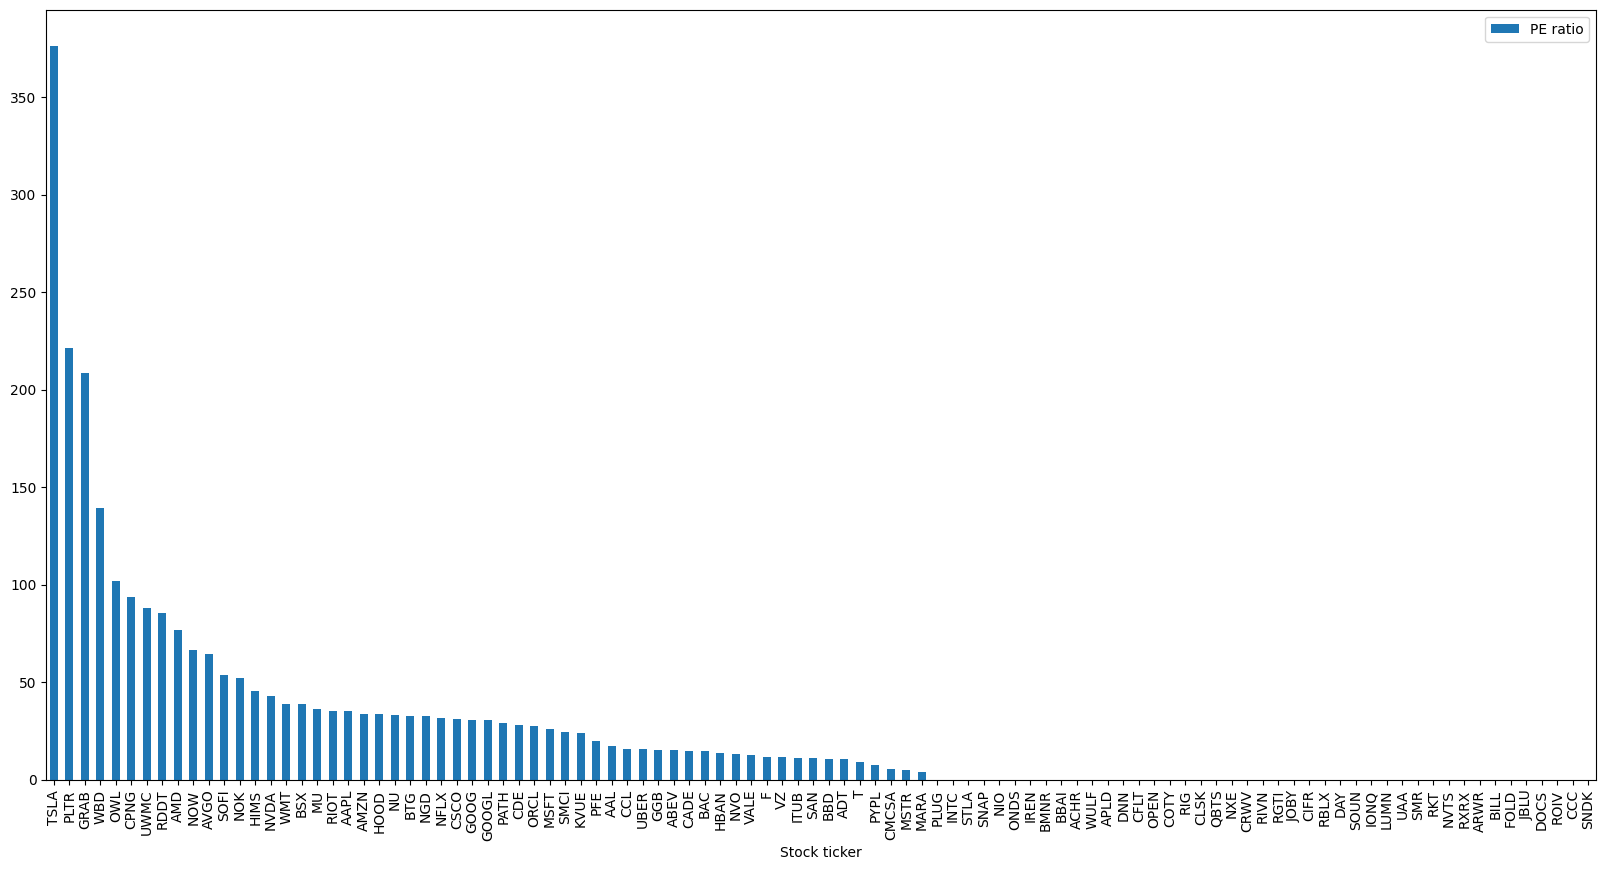

In [121]:
order_by_pe_ratio_df.plot(x ='Stock ticker', y='PE ratio', kind = 'bar',figsize=(20,10))
plt.show()

A plot that shows stocks from the 100 most active stocks from highest to lowest volume.

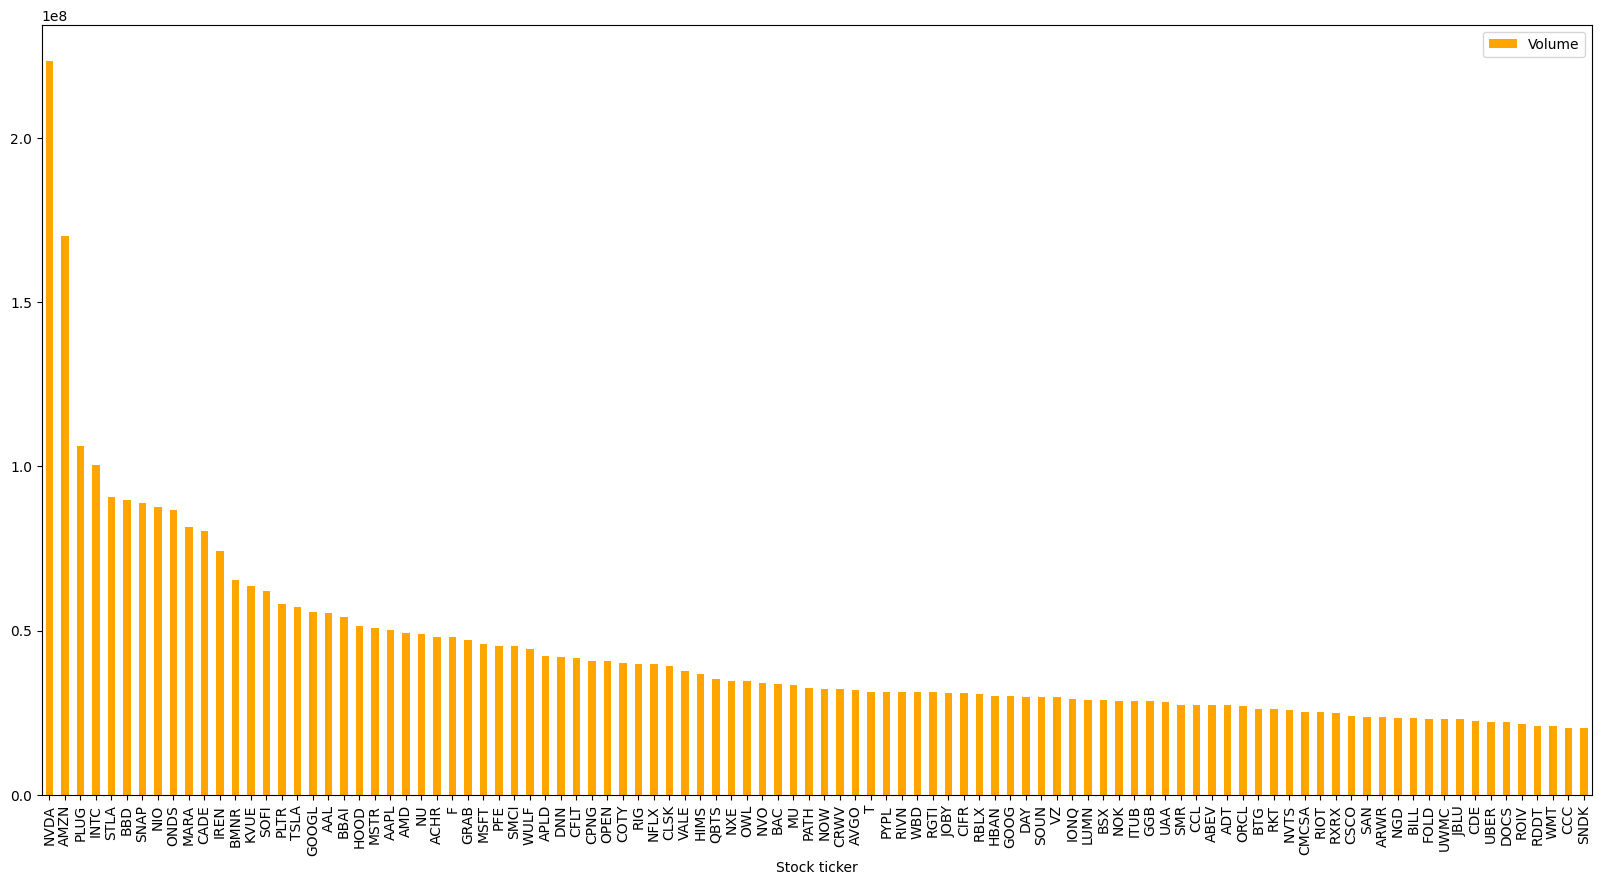

In [122]:
order_by_vol_df.plot(x ='Stock ticker', y='Volume', kind = 'bar',figsize=(20,10),color='orange')
plt.show()

A plot that shows stocks from the 100 most active stocks from cheapest to most expensive.

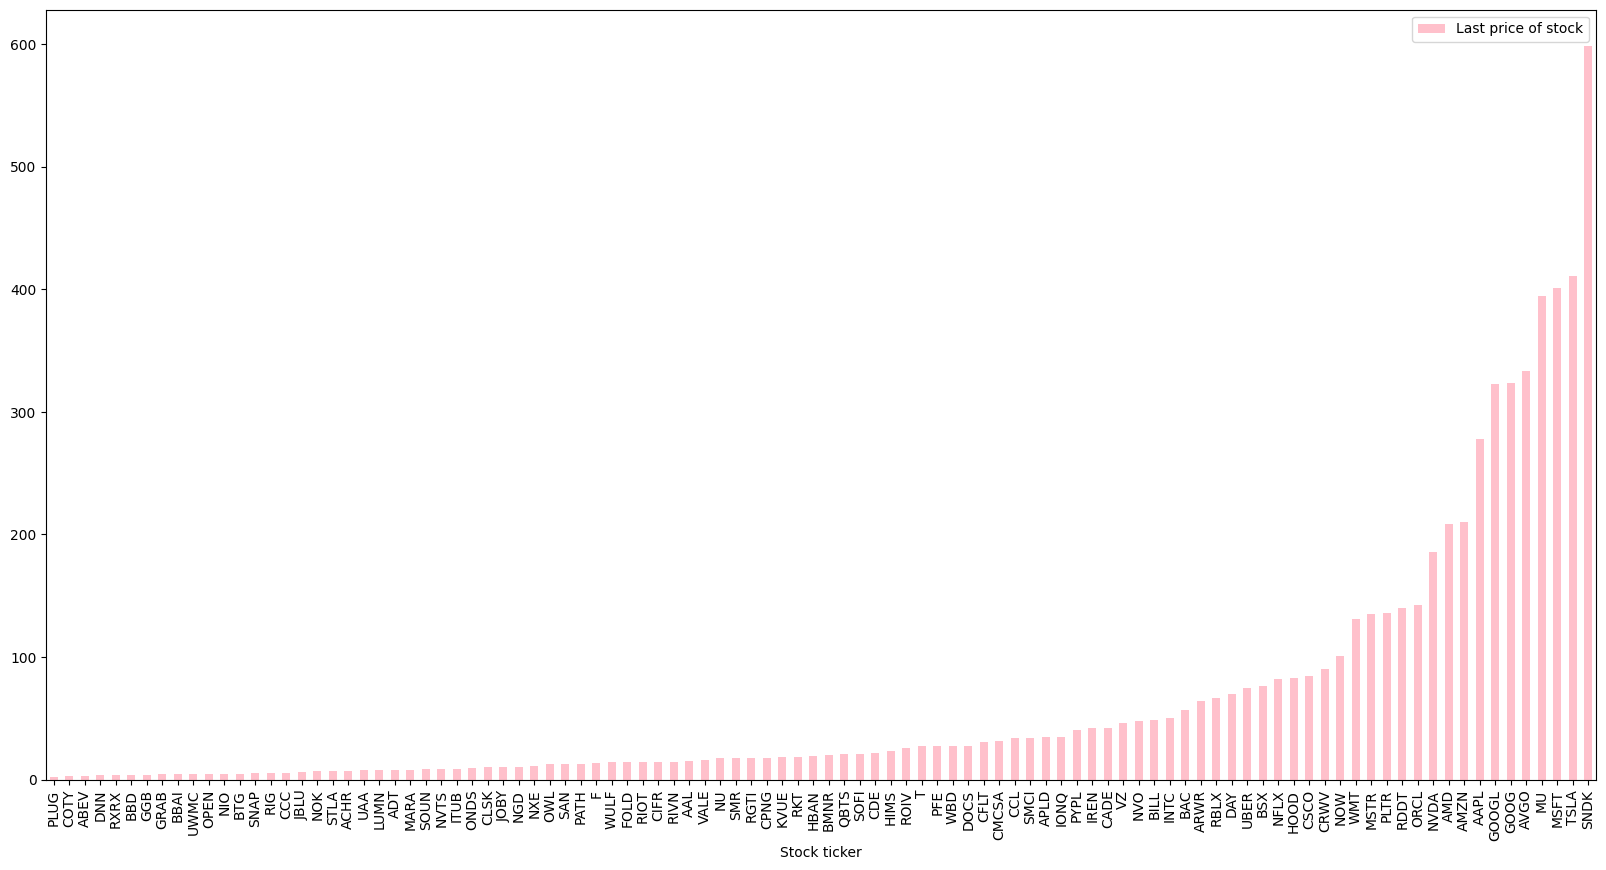

In [123]:
order_by_price_df.plot(x ='Stock ticker', y='Last price of stock', kind = 'bar',figsize=(20,10),color='pink')
plt.show()

### 8. Summary

In summary, we've downloaded two articles, parsed them for information, created functions to create dictionaries of the parsed information, saved those dictionaries as CSV files, converted those CSV files to pandas data frames, and finally, visualised a few of those data frames.

This project is meant to be informative and general in nature, it is not applicable to anyone's personal situation.

### 9. Future work ideas

In the future, I would love to gather more information on individual stocks such as historical data so that we can look at comparisons of stocks historically. I would also like to delve deeper into data displays and derive useful inferences that can be used for educational purposes. I think this project can be used as a springboard for my goal of shrinking the wealth gap.

### 10. References

* “Cryptocurrency List & Prices, Top Cryptocurrencies.” Yahoo! Finance, Yahoo!, 20 Aug. 2022, https://finance.yahoo.com/cryptocurrencies/.
* “Girls That Invest Podcast & Masterclass.” Girls That Invest, https://girlsthatinvest.com/.
* “Most Active Stocks Today.” Yahoo! Finance, Yahoo!, 20 Aug. 2022, https://finance.yahoo.com/most-active?offset=0&amp;count=100.

In [124]:
!pip install jovian --upgrade --quiet

In [125]:
import jovian

In [126]:
jovian.commit(files=['most-active-stocks-next-page.csv', 'most-active-stocks.csv'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
